# In this notebook you can choose between analytical (w41) vs automatic (w42) gradients.
## Start by setting up global stuff

In [108]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import jax.numpy as jnp
from jax import grad

In [109]:
# Global parameters
N = 128  # no. data points
N_epoch = 1000  # max no. epochs/iterations before stopping
noise_std = 0.1  # standard deviation of noise
lmbda = 0.001  # Ridge hyperparameter lambda
theta_tol = 1e-7  # theta tolerance for stopping iteration when |theta_new - theta_old| <= theta_tol
rng_seed = 2023  # seed for generating psuedo-random values
HEATMAP_CMAP = "coolwarm"  # colormap for seaborn heatmap plots

epoch_iters = range(N_epoch)  # for plotting

# Create data set
rng = np.random.default_rng(rng_seed)
x = rng.random((N, 1))
noise = rng.normal(0, noise_std, x.shape)
y = 5 - 10 * x + 2 * x**2 + noise

# Analytical calculations for comparing
X = np.c_[np.ones((N, 1)), x]  # design matrix

# Create class for OLS and Ridge, with both analytical and automatical gradiant calculations

In [110]:
class OLS:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.N = y.size
        self.automatic_grad = grad(self.cost_func)

    def cost_func(self, theta):
        return 1 / self.N * jnp.sum((self.y - self.X @ theta)**2)

    def analytic_grad(self, theta):
        return 2 / self.N * self.X.T @ (self.X @ theta - self.y)


class Ridge(OLS):
    def __init__(self, X, y, lmbda):
        super().__init__(X, y)
        self.lmbda = lmbda
        self.automatic_grad = grad(self.cost_func)

    def cost_func(self, theta):
        return 1 / self.N * jnp.sum((self.y - self.X @ theta)**2) + lmbda * jnp.sum(jnp.abs(theta))

    def analytic_grad(self, theta):
        return 2 / self.N * (self.X.T @ (self.X @ theta - self.y) + lmbda * theta)


In [111]:
### Initialize objects used for the whole task
ols = OLS(X, y)
ridge = Ridge(X, y, lmbda)

### Differentiation method choice
# grad_ols = ols.analytic_grad  # use analytical expression
# grad_ridge = ridge.analytic_grad
grad_ols = ols.automatic_grad  # use jax automatic differentiation
grad_ridge = ridge.automatic_grad
###

In [112]:
######## Print values

# own OLS inversion
theta_ols = np.linalg.inv(X.T @ X) @ (X.T @ y)

# Hessian matrices 
H_ols = 2 / N * X.T @ X
eig_ols, _ = np.linalg.eig(H_ols)
max_eig_ols = 1 / max(eig_ols)

print(f"OLS:\n1/lambda_max={max_eig_ols:.3f}")
print(f"2/lambda_max={2*max_eig_ols:.3f}")
print(f"Theta from inversion={theta_ols.ravel()}")

# own ridge inversion
XT_X = X.T @ X
I = np.identity(np.shape(XT_X)[0])
lmbda_I = lmbda * I
theta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y) 

# Hessian matrix
H = 2 / N * XT_X + 2 * lmbda_I 
eig_ridge, _ = np.linalg.eig(H)
max_eig_ridge = 1 / max(eig_ridge)

print(f"\nRidge:\n1/lambda_max={max_eig_ridge:.3f}")
print(f"2/lambda_max={2*max_eig_ridge:.3f}")
print(f"Theta from inversion={theta_ridge.ravel()}")

OLS:
1/lambda_max=0.390
2/lambda_max=0.779
Theta from inversion=[ 4.63898721 -7.93024817]

Ridge:
1/lambda_max=0.389
2/lambda_max=0.779
Theta from inversion=[ 4.63843602 -7.92924881]


# 1. Plain gradient descent (GD) convergence with fixed learning rate

OLS theta=[ 4.6389856 -7.9302454], error=2.832e-02 converged after 165 iterations.
Ridge theta=[ 4.6336465 -7.920854 ], error=4.088e-02 converged after 166 iterations.


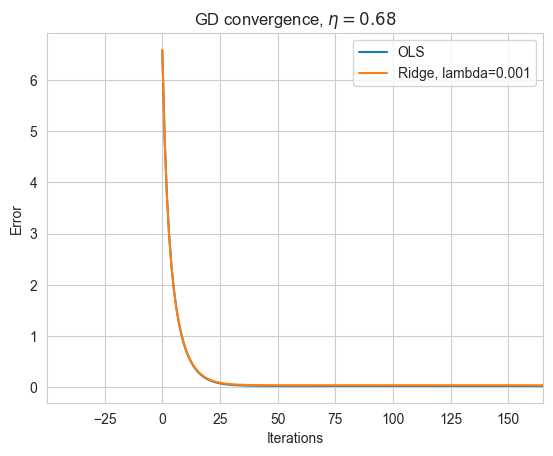

In [113]:
# Parameters
learn_rate = 0.68  # learning rate

# store the theta errors for each iter
errors_gd_ols = np.zeros(N_epoch)
errors_gd_ridge = np.zeros_like(errors_gd_ols)

# begin with theta guess
theta_gd_ols = rng.standard_normal((2, 1))  
theta_gd_ridge = theta_gd_ols.copy()

# OLS loop
theta_gd_ols_prev = np.zeros(theta_gd_ols.shape)
for epoch_ols in epoch_iters:
    theta_gd_ols_prev = theta_gd_ols.copy()
    
    # Plain gradient descent: update theta
    theta_gd_ols -= learn_rate * grad_ols(theta_gd_ols)
    
    # Store MSE as error
    errors_gd_ols[epoch_ols] = ols.cost_func(theta_gd_ols)
    
    # Convergence test
    if all(abs(theta_gd_ols - theta_gd_ols_prev) <= theta_tol):
        errors_gd_ols[epoch_ols:] = errors_gd_ols[epoch_ols]
        break
    
# Ridge loop
theta_gd_ridge_prev = np.zeros(theta_gd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_gd_ridge_prev = theta_gd_ridge.copy()
    
    # Plain gradient descent: update theta
    theta_gd_ridge -= learn_rate * grad_ridge(theta_gd_ridge)
    
    # Store MSE as error
    errors_gd_ridge[epoch_ridge] = ridge.cost_func(theta_gd_ridge)
    
    # Convergence test
    if all(abs(theta_gd_ridge - theta_gd_ridge_prev) <= theta_tol):
        errors_gd_ridge[epoch_ridge:] = errors_gd_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gd_ols, label="OLS")
plt.plot(epoch_iters, errors_gd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"GD convergence, $\eta={learn_rate:.2f}$")
plt.xlim(right=epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gd_ols.ravel()}, error={errors_gd_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(f"Ridge theta={theta_gd_ridge.ravel()}, error={errors_gd_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

The choice of fixed learning rate $\eta=0.68$ gave the fastest convergence with the same error value. This is still below $2/\lambda_{max}=0.77$. 

# 2. Gradient descent with momentum/memory (GDM) convergence with fixed learning rate

OLS theta=[ 4.638991  -7.9302554], error=2.832e-02 converged after 63 iterations.
Ridge theta=[ 4.633648 -7.920856], error=4.088e-02 converged after 75 iterations.


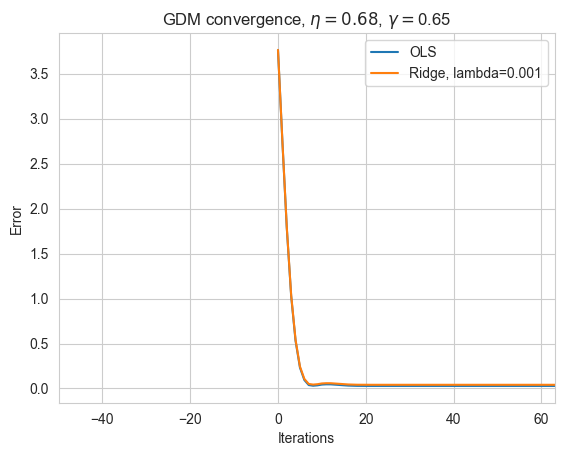

In [114]:
# Parameters
learn_rate = learn_rate  # learning rate, use same as for GD
momentum_rate = 0.65  # momentum rate

# store the theta errors for each iter
errors_gdm_ols = np.zeros(N_epoch)
errors_gdm_ridge = np.zeros_like(errors_gdm_ols)

# begin with theta guess
theta_gdm_ols = rng.standard_normal((2, 1))  
theta_gdm_ridge = theta_gdm_ols.copy()

# OLS loop
theta_gdm_ols_prev = np.zeros(theta_gdm_ols.shape)
change = 0
for epoch_ols in epoch_iters:
    theta_gdm_ols_prev = theta_gdm_ols.copy()
    
    # GDM change 
    new_change = learn_rate * grad_ols(theta_gdm_ols) + momentum_rate * change
    
    # Update values
    theta_gdm_ols -= new_change
    change = new_change.copy()
    
    # Store MSE as error
    errors_gdm_ols[epoch_ols] = ols.cost_func(theta_gdm_ols)
    
    # Convergence test
    if all(abs(theta_gdm_ols - theta_gdm_ols_prev) <= theta_tol):
        errors_gdm_ols[epoch_ols:] = errors_gdm_ols[epoch_ols]
        break
    
# Ridge loop
theta_gdm_ridge_prev = np.zeros(theta_gdm_ridge.shape)
change = 0
for epoch_ridge in epoch_iters:
    theta_gdm_ridge_prev = theta_gdm_ridge.copy()
    
    # GDM change 
    new_change = learn_rate * grad_ridge(theta_gdm_ridge) + momentum_rate * change
    
    # Update values
    theta_gdm_ridge -= new_change
    change = new_change.copy()
    
    # Store MSE as error
    errors_gdm_ridge[epoch_ridge] = ridge.cost_func(theta_gdm_ridge)
    
    # Convergence test
    if all(abs(theta_gdm_ridge - theta_gdm_ridge_prev) <= theta_tol):
        errors_gdm_ridge[epoch_ridge:] = errors_gdm_ridge[epoch_ridge]
        break

plt.plot(epoch_iters, errors_gdm_ols, label="OLS")
plt.plot(epoch_iters, errors_gdm_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Iterations")
plt.ylabel(r"Error")
plt.title(f"GDM convergence, $\eta={learn_rate:.2f}$, $\gamma=${momentum_rate:.2f}")
plt.xlim(right=epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_gdm_ols.ravel()}, error={errors_gdm_ols[-1]:.3e}, converged after {epoch_ols} iterations.")
print(f"Ridge theta={theta_gdm_ridge.ravel()}, error={errors_gdm_ridge[-1]:.3e}, converged after {epoch_ridge} iterations.")

Clearly using momentum provides a bit faster convergence, although (at least for this example) the same error. This choice of momentum rate $\gamma\approx0.65$ gave the fastest convergence. I would think that for other more complex examples adding momentum would be even more beneficial than this was.

# 3. Stochastic gradient descent (SGD) with replacement convergence

In [ ]:
# Parameters
M = 64  # size of each minibatch
m = int(N/M)  # number of minibatches

def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    t0 = 5
    t1 = 50
    return t0 / (t + t1)


# store the theta errors for each iter
errors_sgd_ols = np.zeros(N_epoch)
errors_sgd_ridge = np.zeros_like(errors_sgd_ols)

# begin with theta guess
theta_sgd_ols = rng.standard_normal((2, 1))  
theta_sgd_ridge = theta_sgd_ols.copy()

# OLS loop
theta_sgd_ols_prev = np.zeros(theta_sgd_ols.shape)
for epoch_ols in epoch_iters:
    theta_sgd_ols_prev = theta_sgd_ols.copy()
    
    # Iterate through all minibatches for each epoch iteration
    for i in range(m): 
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        
        # Gradient descent on the random batch
        gradient = grad_ols(theta_sgd_ols)
        learn_rate = learning_schedule(epoch_ols * m + i)
        
        # Update theta
        theta_sgd_ols -= learn_rate * gradient
    
    # Store MSE as error for each epoch iteration
    errors_sgd_ols[epoch_ols] = ols.cost_func(theta_sgd_ols)
    
    # Convergence test
    if all(abs(theta_sgd_ols - theta_sgd_ols_prev) <= theta_tol):
        errors_sgd_ols[epoch_ols:] = errors_sgd_ols[epoch_ols]
        break
    
    
# Ridge loop
theta_sgd_ridge_prev = np.zeros(theta_sgd_ridge.shape)
for epoch_ridge in epoch_iters:
    theta_sgd_ridge_prev = theta_sgd_ridge.copy()
    
    # Iterate through all minibatches for each epoch iteration
    for i in range(m): 
        # Pick a minibatch at random from the data set
        random_index = M * rng.integers(m)
        xi = X[random_index:random_index + M]
        yi = y[random_index:random_index + M]
        
        # Gradient descent on the random batch
        gradient = grad_ridge(theta_sgd_ridge)
        learn_rate = learning_schedule(epoch_ridge * m + i)
        
        # Update theta
        theta_sgd_ridge -= learn_rate * gradient
        
    # Store MSE as error for each epoch iteration
    errors_sgd_ridge[epoch_ridge] = ridge.cost_func(theta_sgd_ridge)
    
    # Convergence test
    if all(abs(theta_sgd_ridge - theta_sgd_ridge_prev) <= theta_tol):
        errors_sgd_ridge[epoch_ols:] = errors_sgd_ridge[epoch_ols]
        break


# Plot errors as function of epoch iteration
plt.plot(epoch_iters, errors_sgd_ols, label="OLS")
plt.plot(epoch_iters, errors_sgd_ridge, label=f"Ridge, lambda={lmbda}")
plt.xlabel("Epoch")
plt.ylabel(r"Error")
plt.title(f"SGD convergence, $\eta={learn_rate:.2f}$")
plt.xlim(right=epoch_ols)
plt.grid(True)
plt.legend()

# Print theta values and convergence times
print(f"OLS theta={theta_sgd_ols.ravel()}, error={errors_sgd_ols[-1]:.3e}, converged after {epoch_ols} epochs.")
print(f"Ridge theta={theta_sgd_ols.ravel()}, error={errors_sgd_ridge[-1]:.3e}, converged after {epoch_ridge} epochs.")

# 3. Stochastic gradient descent with momentum (SGDM) as function of batch size $M$ and number of epochs $N_\text{epochs}$, with replacement

### OLS:

In [14]:
# SDG parameters
M_vals = np.asarray([1, 2, 4, 8, 16, 32, 64, 128])  # size of each minibatch
N_epoch_vals = [1, 10, 100, 1000]  # number of iterations over all the minibatches 
momentum_rates = [0.1, 0.3, 0.4, 0.5, 0.75, 0.95]  # momentum rate

m_vals = (N / M_vals).astype(int)  # number of minibatches


def learning_schedule(t):
    """Function for a scaling learning rate, it reduces over time/iterations."""
    t0 = 5
    t1 = 50
    return t0 / (t + t1)

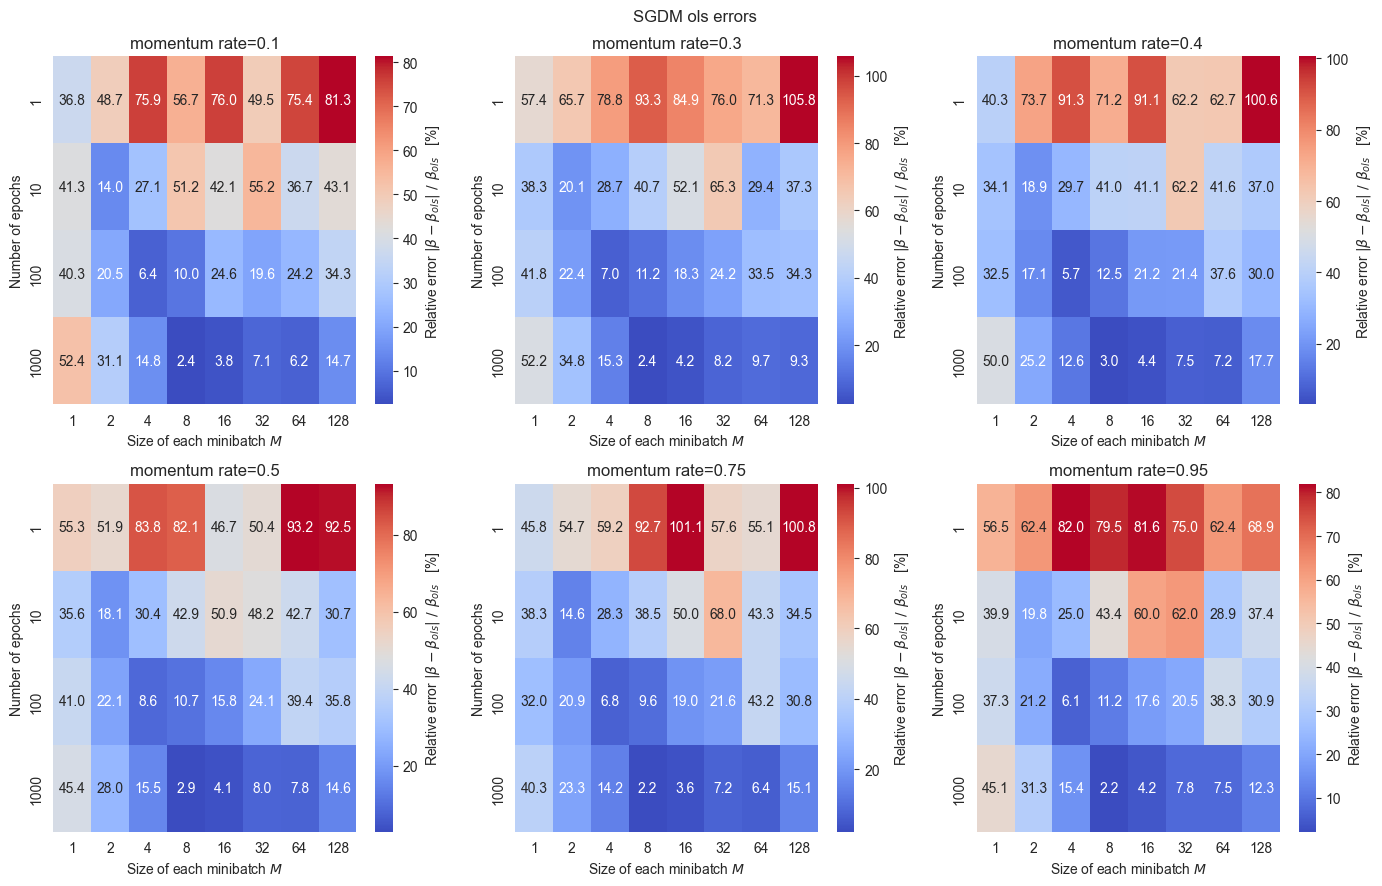

In [15]:
# Plot error heatmap for each different momentum rate value
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 9))
fig.suptitle("SGDM ols errors")

for l, momentum_rate in enumerate(momentum_rates):
    rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))

    # iterate through different epochs values
    for j, N_epoch in enumerate(N_epoch_vals):

        # then iterate through different values of total number of batches m (and corresponding M)
        for i, m in enumerate(m_vals):
            M = M_vals[j]
            beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]
            change = 0

            # then iterate through all different epoch values
            for epoch in range(N_epoch):

                # now do the GD calculation for each of the minibatches
                for k in range(m):

                    # Pick a minibatch at random
                    random_index = M * rng.integers(m)
                    xk = X[random_index:random_index + M]
                    yk = y[random_index:random_index + M]

                    # Gradient descent on the random batch
                    gradients = 2 / M * xk.T @ ((xk @ beta) - yk)
                    learn_rate = learning_schedule(epoch * m + k)
                    new_change = learn_rate * gradients + momentum_rate * change

                    # Update vals
                    beta -= learn_rate * gradients
                    change = new_change.copy()
            rel_errors[i, j] = np.max(abs(beta - beta_ols) / beta_ols)

    ### Plot error heatmap

    # find row and col indices
    if l < ncols:
        row = 0
        col = l
    else:
        row = 1
        col = l - ncols
    im = sb.heatmap(
            rel_errors.T * 100,
            ax=axs[row, col],
            annot=True,
            fmt=".1f",
            cmap=HEATMAP_CMAP,
            xticklabels=M_vals,
            yticklabels=N_epoch_vals,
            cbar_kws={"label": r"Relative error $|\beta - \beta_{ols}|\ /\ \beta_{ols}$   [%]"}  # colorbar label
    )
    axs[row, col].set_title(f"momentum rate={momentum_rate}")
    axs[row, col].set_ylabel("Number of epochs")
    axs[row, col].set_xlabel("Size of each minibatch $M$")
fig.tight_layout()

### Ridge with momentum rate $=0.4$

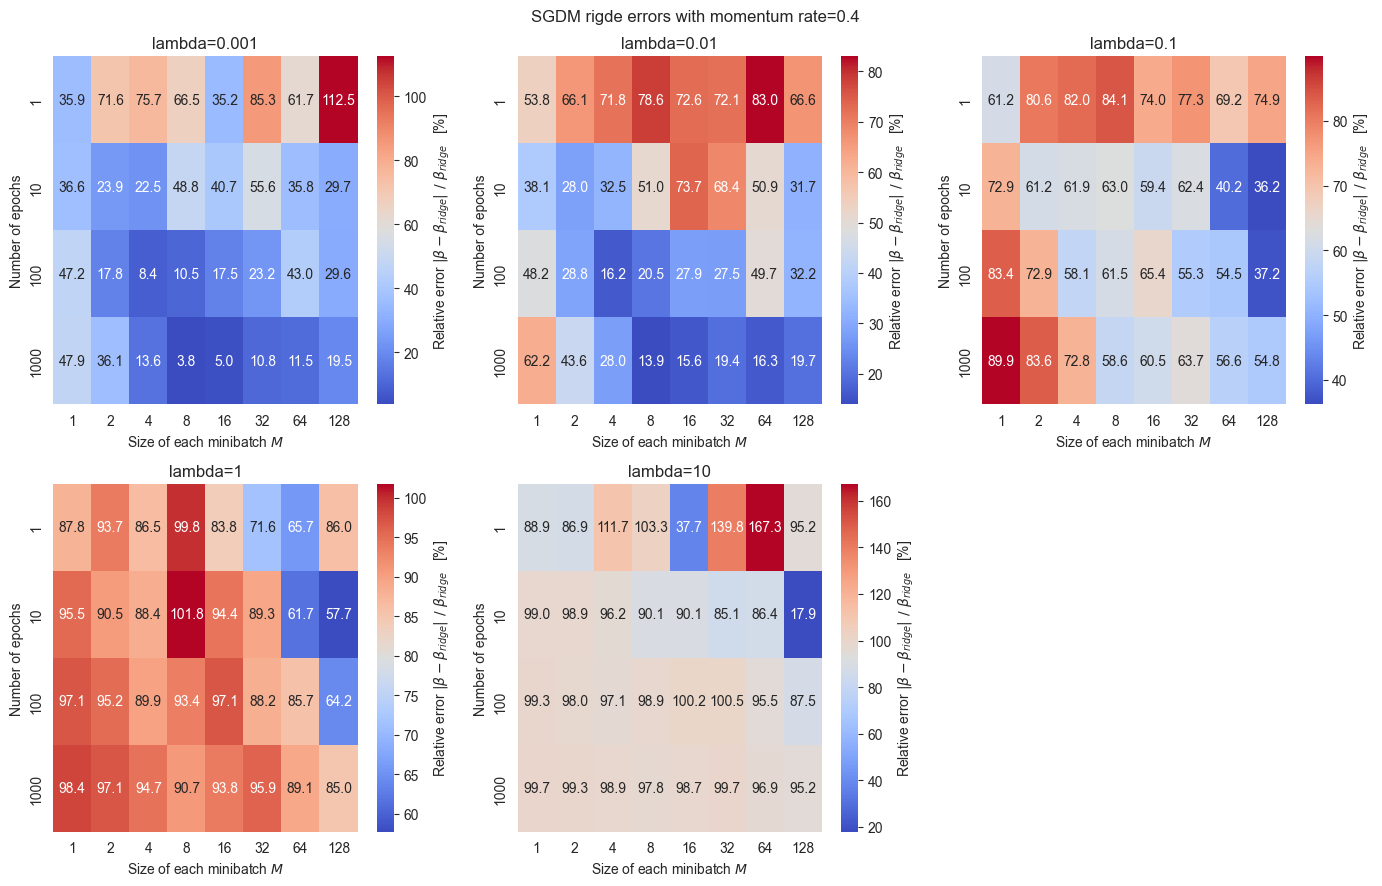

In [17]:
# Ridge parameter
lmdbas = [0.001, 0.01, 0.1, 1, 10]
momentum_rate = 0.4

# Plot error heatmap for each different lambda value
nrows, ncols = 2, 3
fig, axs = plt.subplots(nrows, ncols, figsize=(14, 9))
fig.suptitle(f"SGDM rigde errors with momentum rate={momentum_rate}")

# Remove the final subplot which is not used
axs[-1, -1].remove()

XT_X = X.T @ X
for l, lmbda in enumerate(lmdbas):
    # own Ridge inversion
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I
    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)

    rel_errors = np.empty((M_vals.size, len(N_epoch_vals)))

    # iterate through different epochs values
    for j, N_epoch in enumerate(N_epoch_vals):

        # then iterate through different values of total number of batches m (and corresponding M)
        for i, m in enumerate(m_vals):
            M = M_vals[j]
            beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1]
            change = 0

            # then iterate through all different epoch values
            for epoch in range(N_epoch):

                # now do the GD calculation for each of the minibatches
                for k in range(m):

                    # Pick a minibatch at random
                    random_index = M * rng.integers(m)
                    xk = X[random_index:random_index + M]
                    yk = y[random_index:random_index + M]

                    # Gradient descent on the random batch
                    gradients = 2 / M * xk.T @ ((xk @ beta) - yk) + 2 * lmbda * beta
                    learn_rate = learning_schedule(epoch * m + k)
                    new_change = learn_rate * gradients + momentum_rate * change

                    # Update vals
                    beta -= learn_rate * gradients
                    change = new_change.copy()
            rel_errors[i, j] = np.max(abs(beta - beta_ridge) / beta_ridge)

    ### Plot error heatmap

    # find row and col indices
    if l < ncols:
        row = 0
        col = l
    else:
        row = 1
        col = l - ncols
    im = sb.heatmap(
            rel_errors.T * 100,
            ax=axs[row, col],
            annot=True,
            fmt=".1f",
            cmap=HEATMAP_CMAP,
            xticklabels=M_vals,
            yticklabels=N_epoch_vals,
            cbar_kws={"label": r"Relative error $|\beta - \beta_{ridge}|\ /\ \beta_{ridge}$   [%]"}  # colorbar label
    )
    axs[row, col].set_title(f"lambda={lmbda}")
    axs[row, col].set_ylabel("Number of epochs")
    axs[row, col].set_xlabel("Size of each minibatch $M$")

fig.tight_layout()

### 4. Tuning the learning rate with Adagrad for plain GD

### OLS:

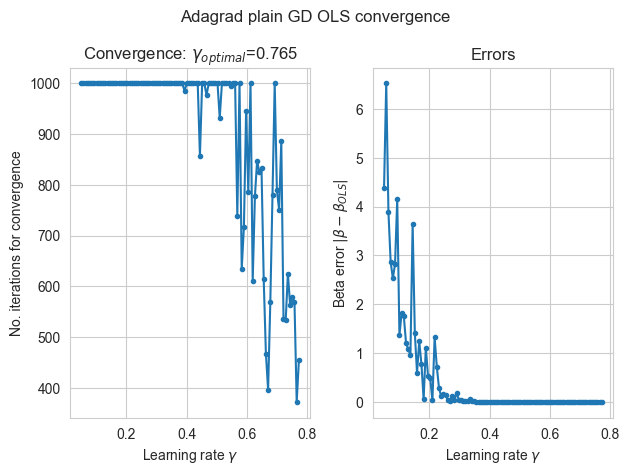

In [37]:
# Parameters
learn_rates = np.linspace(0.05, 2 / np.max(eig_ols), 100, endpoint=False)
delta = 1e-8

no_iters = np.empty(learn_rates.size)  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

error_best = 1e10
beta_best = 0
for i, learn_rate in enumerate(learn_rates):
    # Iterate through and improve beta
    beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
    beta_prev = 0
    r = 0
    iter = 0
    while iter < N_epoch and any(abs(beta - beta_prev) > theta_tol):  # convergence test
        beta_prev = beta.copy()

        # Update beta using Adagrad algorithm
        grad = 2 / N * X.T @ (X @ beta - y)
        r += grad * grad
        beta -= grad * learn_rate / (delta + np.sqrt(r))

        iter += 1
    no_iters[i] = iter

    error = np.max(abs(beta - beta_ols))
    if error < error_best:
        error_best = error
        beta_best = beta
    errors[i] = error

fig, axs = plt.subplots(1, 2)
fig.suptitle(f"Adagrad plain GD OLS convergence")

# Plot convergence
axs[0].plot(learn_rates, no_iters, ".-")
axs[0].set_title("Convergence: $\gamma_{optimal}$=" + f"{learn_rates[np.argmin(no_iters)]:.3f}")
axs[0].set_xlabel("Learning rate $\gamma$")
axs[0].set_ylabel("No. iterations for convergence")
axs[0].grid(True)

# Plot error
axs[1].plot(learn_rates, errors, ".-")
axs[1].set_title("Errors")
axs[1].set_xlabel("Learning rate $\gamma$")
axs[1].set_ylabel(r"Beta error $|\beta - \beta_{OLS}|$")
axs[1].grid(True)

plt.tight_layout()

### Ridge:

lmbda=0.001, beta_ridge=[ 4.63843602 -7.92924881], beta=[ 4.56952864 -7.80431839], max error=0.12493068207063907
lmbda=0.01, beta_ridge=[ 4.63348146 -7.9202657 ], beta=[ 4.03000379 -6.8266078 ], max error=1.093657659430578
lmbda=0.1, beta_ridge=[ 4.58453656 -7.83152704], beta=[ 1.906442   -2.99719636], max error=4.834330785954755
lmbda=1, beta_ridge=[ 4.14853073 -7.04132091], beta=[ 0.38194457 -0.40986897], max error=6.6314519400789145
lmbda=10, beta_ridge=[ 2.17463702 -3.47741008], beta=[ 0.05197307 -0.03689588], max error=3.440514205444413


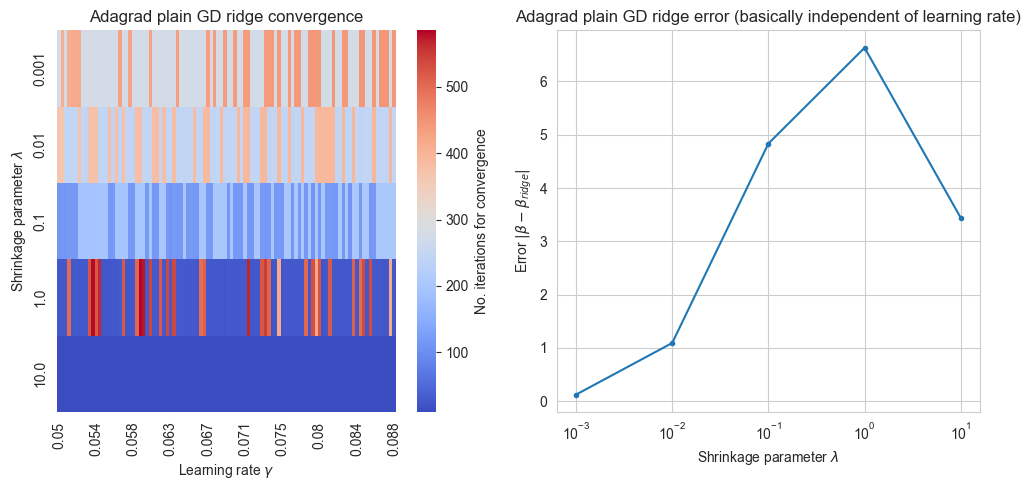

In [40]:
# Parameters
ridge_lambdas = [0.001, 0.01, 0.1, 1, 10]  # lambda vals to plot
delta = 1e-8

no_iters = np.empty((learn_rates.size, len(ridge_lambdas)))  # store the number of iterations needed to converge
errors = np.empty_like(no_iters)  # store the beta errors

# Iterate through each lambda and each learning rate and test convergence
for j, lmbda in enumerate(ridge_lambdas):
    # Calculate max eigenvalue
    XT_X = X.T @ X
    I = np.identity(np.shape(XT_X)[0])
    lmbda_I = lmbda * I

    beta_ridge = np.linalg.inv(XT_X + lmbda_I) @ (X.T @ y)  # own Ridge inversion
    H = 2 / N * XT_X + 2 * lmbda_I  # Hessian matrix
    eig_ridge, iter = np.linalg.eig(H)

    # Create learning rate values to test 
    learn_rates = np.linspace(0.05, 2 / np.max(eig_ridge), 100, endpoint=False)
    for i, learn_rate in enumerate(learn_rates):
        # Iterate through and improve beta
        beta = rng.standard_normal((2, 1))  # create 2 random beta parameters [b_0, b_1] to test convergence with
        beta_prev = 0
        r = 0
        iter = 0
        while iter < N_epoch and any(abs(beta - beta_prev) > theta_tol):  # convergence test
            beta_prev = beta.copy()

            # Update beta
            grad = 2 / N * X.T @ (X @ beta - y) + 2 * lmbda * beta
            r += grad * grad
            beta -= learn_rate * grad / (delta * np.sqrt(r))

            # stop if beta is blowing up -> will overflow
            if any(beta > 1e8):
                iter = 1000
                break

            iter += 1
        no_iters[i, j] = iter
        errors[i, j] = np.max(abs(beta - beta_ridge))
    print(f"{lmbda=}, beta_ridge={beta_ridge.ravel()}, beta={beta.ravel()}, max error={errors[0, j]}")

# Heatmap plotting
plt.figure(figsize=(10, 5))

###### Convergence heatmap
# Set xlabel ticks to show a total of 10 values, with 3 decimal places
xticks = np.round(learn_rates, 3)
keptticks = xticks[::int(len(learn_rates) / 10) + 1]
xticks = ['' for _ in xticks]
xticks[::int(len(xticks) / 10) + 1] = keptticks

plt.subplot(1, 2, 1)
ax = sb.heatmap(
        no_iters.T,
        annot=False,
        cmap=HEATMAP_CMAP,
        xticklabels=xticks,
        yticklabels=np.round(ridge_lambdas, 3),
        cbar_kws={"label": "No. iterations for convergence"}  # colorbar label
)
plt.xticks(rotation=90)  # sideways xticks
plt.title("Adagrad plain GD ridge convergence")
plt.xlabel("Learning rate $\gamma$")
plt.ylabel("Shrinkage parameter $\lambda$")
######


###### Error plot
plt.subplot(1, 2, 2)
plt.plot(ridge_lambdas, errors[0, :], ".-")  # the errors are almost the same for each learning rate value
plt.title("Adagrad plain GD ridge error (basically independent of learning rate)")
plt.ylabel(r"Error $|\beta-\beta_{ridge}|$")
plt.xlabel("Shrinkage parameter $\lambda$")
plt.xscale("log")
###### 

plt.tight_layout()